In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sql_queries import main_query
from common_functions import open_connection, translate_products

### **Basic Setup**

#### **Functions**

In [3]:
def missing_value_table(data):
    """Creating Summary Table for Missing Value in Dataset

    Creating Table containing total of missing value and its percentage
    of each feature/column on the dataset.

    Parameters
    ----------
    data : pandas.DataFrame
        The data we want to get the missing value

    Returns
    -------
    table : pandas.DataFrame
        Summary Table for Missing Value
    """
    
    missing_value_count = data.isna().sum()
    missing_value_percent = ((data.isna().sum()/data.count())*100).round(3)

    content = {
            "Missing Data": missing_value_count, 
            "Percentage (%)": missing_value_percent
        }

    table = pd.DataFrame(content)
    return table


In [4]:
def outliers_table(data, col_name, replace=False):
    """Create outliers table and replace outliers
    
    Parameters
    ----------
    data : pandas.DataFrame
        pandas data frame object
    col_name : str
        name of the data frame columns
    replace : bool
        whether outliers would be replaced or not

    Returns
    -------
    outliers : pandas.DataFrame
        the outliers table in data frame
    """

    q1 = data[col_name].quantile(.25)
    q3 = data[col_name].quantile(.75)
    iqr = q3 - q1

    lower_iqr = data[col_name] < q1 - 1.5*iqr
    upper_iqr = data[col_name] > q3 + 1.5*iqr

    if replace:
        new_outliers_value = data[col_name].median()
        data.loc[lower_iqr | upper_iqr, col_name] = new_outliers_value
        data[lower_iqr | upper_iqr][col_name].head()
    else:
        outliers = data[lower_iqr | upper_iqr]
        return outliers


In [5]:
import textwrap


def wrap_labels(ax, width, break_long_words=False):
    """Wrapping Graph xtick value
    
    Parameters:
    -----------
    ax : matplotlib.Axes
        Matplotlib Axes object
    width : int
        Maximum allowed text width
    break_long_words : boolean
        Break text if it is too long
    """
    
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                    break_long_words=break_long_words))
    
    ax.set_xticklabels(labels, rotation=0)

#### **Import Query and Get Basic Info of the Table**

In [6]:
connection = open_connection("olist.db")

Connection is successful


In [7]:
df_main = pd.read_sql(main_query, connection)

In [8]:
print(f"Dataset Shape: {df_main.shape}\n")
df_main.info()

Dataset Shape: (114092, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114092 entries, 0 to 114091
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      114092 non-null  object 
 1   seller_id     113314 non-null  object 
 2   product_name  111702 non-null  object 
 3   price         113314 non-null  float64
 4   review_score  113131 non-null  float64
dtypes: float64(2), object(3)
memory usage: 4.4+ MB


### **Data Processing**

#### **Finding Missing Values**

In [9]:
missing_value_table(df_main)

,Missing Data,Percentage (%)
order_id,0,0.000
seller_id,778,0.687
product_name,2390,2.140
price,778,0.687
review_score,961,0.849


##### Processing - Product Name Missing Value 

In [10]:
df_main[df_main["product_name"].isna()]

,order_id,seller_id,product_name,price,review_score
6,136cce7faa42fdb2cefd53fdc79a6098,dc8798cbf453b7e0f98745e396cc5616,None,49.90,2.0
122,bfe42c22ecbf90bc9f35cf591270b6a7,e5a3438891c0bfdb9394643f95273d8e,None,27.30,5.0
212,58ac1947c1a9067b9f416cba6d844a3f,520b493b57809f446cb0a233bb3e25c7,None,110.00,5.0
264,e22b71f6e4a481445ec4527cb4c405f7,6cd68b3ed6d59aaa9fece558ad360c0a,None,22.50,4.0
303,a094215e786240fcfefb83d18036a1cd,c826c40d7b19f62a09e2d7c5e7295ee2,None,122.99,5.0
...,...,...,...,...,...
113871,aaab15da689073f8f9aa978a390a69d1,None,None,NaN,1.0
113903,3a3cddda5a7c27851bd96c3313412840,None,None,NaN,5.0
113991,a89abace0dcc01eeb267a9660b5ac126,None,None,NaN,4.0
113992,a69ba794cc7deb415c3e15a0a3877e69,None,None,NaN,1.0


In [11]:
# Check the missing value on the initial table in the database
product_table_query = """
SELECT
    product_id,
    product_category_name as product_name
FROM olist_products_dataset
"""
df_product_table = pd.read_sql(product_table_query, connection)

df_product_table[df_product_table["product_name"].isna()]

,product_id,product_name
105,a41e356c76fab66334f36de622ecbd3a,None
128,d8dee61c2034d6d075997acef1870e9b,None
145,56139431d72cd51f19eb9f7dae4d1617,None
154,46b48281eb6d663ced748f324108c733,None
197,5fb61f482620cb672f5e586bb132eae9,None
...,...,...
32515,b0a0c5dd78e644373b199380612c350a,None
32589,10dbe0fbaa2c505123c17fdc34a63c56,None
32616,bd2ada37b58ae94cc838b9c0569fecd8,None
32772,fa51e914046aab32764c41356b9d4ea4,None


In [12]:
# Replacing Missing Value in the product_name column
df_main["product_name"].fillna("Unknown", inplace=True)

missing_value_table(df_main)

,Missing Data,Percentage (%)
order_id,0,0.0
seller_id,0,0.0
product_name,0,0.0
price,0,0.0
review_score,0,0.0


##### Processing - seller_id, review_score, price Missing Value 

In [13]:
df_main[df_main["price"].isna()]

,order_id,seller_id,product_name,price,review_score


In [14]:
df_main.dropna(inplace=True)

missing_value_table(df_main)

,Missing Data,Percentage (%)
order_id,0,0.0
seller_id,0,0.0
product_name,0,0.0
price,0,0.0
review_score,0,0.0


#### **Finding Duplicates**

In [15]:
n_duplicates = df_main.duplicated(keep=False).sum()

print("Number of Duplicates: ", n_duplicates)
df_main[df_main.duplicated(keep="first")]

Number of Duplicates:  20006


,order_id,seller_id,product_name,price,review_score
11,e6ce16cb79ec1d90b1da9085a6118aeb,001cca7ae9ae17fb1caed9dfb1094831,ferramentas_jardim,99.0,1.0
55,9faeb9b2746b9d7526aef5acb08e2aa0,f7ba60f8c3f99e7ee4042fdef03b70c4,esporte_lazer,60.0,1.0
61,66e4624ae69e7dc89bd50222b59f581f,db4350fd57ae30082dec7acbaacc17f9,telefonia,22.99,1.0
71,f271576bed568e896f99eb710cd3a6f8,76d64c4aca3a7baf218bf93ef7fa768d,construcao_ferramentas_construcao,329.9,3.0
74,68e48e68da1f50f7c5838ea75e3a20dd,817245bcc3badd82bbd222e0366951a6,automotivo,84.9,5.0
...,...,...,...,...,...
114014,dbd4cbb492a12b99c5224014930acc18,febab0275244b9a49a623f0bd613ca2f,utilidades_domesticas,37.4,4.0
114036,83db27f85506380229913b0dfdf5cd18,7c67e1448b00f6e969d365cea6b010ab,moveis_escritorio,149.94,5.0
114044,b3112ca67f3afd4e20cf2ee91fc4f804,5b0cc932433fa5184b5b94bfe6bcc256,moveis_quarto,95.0,2.0
114063,e8fd20068b9f7e6ec07068bb7537f781,218d46b86c1881d022bce9c68a7d4b15,esporte_lazer,356.0,4.0


In [16]:
# Removing duplicates
df_main.drop_duplicates(keep="first", inplace=True)

# Re-check duplicates
n_duplicates = df_main.duplicated(keep=False).sum()

print("Number of Duplicates: ", n_duplicates)
df_main[df_main.duplicated(keep=False)]

Number of Duplicates:  0


,order_id,seller_id,product_name,price,review_score


#### **Handling Outliers**

In [17]:
# Create Boxplot
sns.boxplot(x=df_main["price"])

#Modify Graph Info
plt.title("Outliers on Price Data")
plt.xlabel("Price")
plt.show()

TypeError: Horizontal orientation requires numeric `x` variable.

In [ ]:
# # Check the 1.5IQR Rule
# q1 = df_main["price"].quantile(.25)
# q3 = df_main["price"].quantile(.75)
# iqr = q3 - q1

# lower_iqr = df_main["price"] < q1 - 1.5*iqr
# upper_iqr = df_main["price"] > q3 + 1.5*iqr

# outliers = df_main[lower_iqr | upper_iqr]

outliers = outliers_table(df_main, "price")

print("Number of Outliers: ", outliers["price"].count())
print("Total of Datapoints: ", df_main["price"].count())
print("Outliers to Total Data Percentage: "\
      + f"{round((outliers['price'].count()/df_main['price'].count())*100, 3)}%")

Number of Outliers:  7548
Total of Datapoints:  99349
Outliers to Total Data Percentage: 7.597%


In [ ]:
# Check the 1.5IQR Rule
# q1 = df_main["price"].quantile(.25)
# q3 = df_main["price"].quantile(.75)
# iqr = q3 - q1

# lower_iqr = df_main["price"] < q1 - 1.5*iqr
# upper_iqr = df_main["price"] > q3 + 1.5*iqr

outliers_table(df_main, "price", True)
df_main

# new_outliers_value = df_main["price"].median()

# df_main.loc[lower_iqr | upper_iqr, "price"] = new_outliers_value
# df_main[lower_iqr | upper_iqr]["price"].head()

,order_id,seller_id,product_name,price,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,utilidades_domesticas,29.99,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,perfumaria,118.70,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,automotivo,159.90,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,66922902710d126a0e7d26b0e3805106,pet_shop,45.00,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2c9e548be18521d1c43cde1c582c6de8,papelaria,19.90,5.0
...,...,...,...,...,...
114086,9c5dedf39a927c1b2549525ed64a053c,e24fc9fcd865784fb25705606fe3dfe7,beleza_saude,72.00,5.0
114087,63943bddc261676b46f01ca7ac2f7bd8,1f9ab4708f3056ede07124aad39a2554,bebes,174.90,4.0
114088,83c1379a015df1e13d02aae0204711ab,d50d79cb34e38265a8649c383dcffd48,eletrodomesticos_2,205.99,5.0
114089,11c177c8e97725db2631073c19f07b62,a1043bafd471dff536d0c462352beb48,informatica_acessorios,179.99,2.0


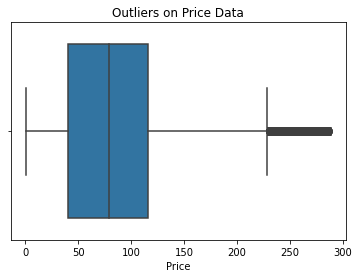

In [ ]:
# Create Boxplot
sns.boxplot(x=df_main["price"])

#Modify Graph Info
plt.title("Outliers on Price Data")
plt.xlabel("Price")
plt.show()

#### **Formatting Data**

In [ ]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99349 entries, 0 to 114091
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      99349 non-null  object 
 1   seller_id     99349 non-null  object 
 2   product_name  99349 non-null  object 
 3   price         99349 non-null  float64
 4   review_score  99349 non-null  float64
dtypes: float64(2), object(3)
memory usage: 4.5+ MB


In [ ]:
# Change review_score data type to integer
df_main["review_score"] = df_main["review_score"].astype(int)

# Check data type changes
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99349 entries, 0 to 114091
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      99349 non-null  object 
 1   seller_id     99349 non-null  object 
 2   product_name  99349 non-null  object 
 3   price         99349 non-null  float64
 4   review_score  99349 non-null  int32  
dtypes: float64(1), int32(1), object(3)
memory usage: 4.2+ MB


##### Translating Product From Portuguese to English

In [ ]:
# Checking Table
df_main.head()

,order_id,seller_id,product_name,price,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,utilidades_domesticas,29.99,4
1,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,perfumaria,118.70,4
2,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,automotivo,159.90,5
3,949d5b44dbf5de918fe9c16f97b45f8a,66922902710d126a0e7d26b0e3805106,pet_shop,45.00,5
4,ad21c59c0840e6cb83a9ceb5573f8159,2c9e548be18521d1c43cde1c582c6de8,papelaria,19.90,5


In [ ]:
df_translation_table = pd.read_sql(translation_table, connection)
translation_map = translate_products(df_translation_table)

df_main.replace(translation_map, inplace=True)
df_main.head()

,order_id,seller_id,product_name,price,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,Housewares,29.99,4
1,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,Perfumery,118.70,4
2,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,Auto,159.90,5
3,949d5b44dbf5de918fe9c16f97b45f8a,66922902710d126a0e7d26b0e3805106,Pet shop,45.00,5
4,ad21c59c0840e6cb83a9ceb5573f8159,2c9e548be18521d1c43cde1c582c6de8,Stationery,19.90,5


In [ ]:
# Re-checking the translated products
products = df_main["product_name"].unique()
not_translated = [product for product in products if "_" in product]
not_translated

['portateis_cozinha_e_preparadores_de_alimentos', 'pc_gamer']

In [ ]:
# Adding unformatted and not translated data
translation_map["pc_gamer"] = "PC Gamer" 
translation_map["portateis_cozinha_e_preparadores_de_alimentos"] = "Kitchen and Food Preparation racks"

# Replacing unformatted and not translated data
df_main["product_name"].replace(translation_map, inplace=True)

# Re-checking the 
products = df_main["product_name"].unique()
not_translated = [product for product in products if "_" in product]
not_translated

[]

In [ ]:
seller_id = df_main["seller_id"].unique()
seller_name = [f"sellers {i}" for i, _ in enumerate(seller_id)]

new_seller_id = dict(zip(seller_id, seller_name))

df_main["seller_id"].replace(new_seller_id, inplace=True)
df_main.head()

,order_id,seller_id,product_name,price,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,sellers 0,Housewares,29.99,4
1,53cdb2fc8bc7dce0b6741e2150273451,sellers 1,Perfumery,118.70,4
2,47770eb9100c2d0c44946d9cf07ec65d,sellers 2,Auto,159.90,5
3,949d5b44dbf5de918fe9c16f97b45f8a,sellers 3,Pet shop,45.00,5
4,ad21c59c0840e6cb83a9ceb5573f8159,sellers 4,Stationery,19.90,5


### **Data Analysis**

#### **Use Case 1: Which products are ordered the most and the least?**

In [ ]:
df_ordered_products = df_main[
        ["product_name", "order_id"]].groupby("product_name").agg("count")

df_ordered_products.head()

,order_id
product_name,
Agro industry and commerce,183
Air conditioning,250
Art,200
Arts and craftmanship,24
Audio,348


In [ ]:
df_ordered_products.reset_index(inplace=True)
df_ordered_products.rename(columns={"order_id": "order_counts"}, inplace=True)

df_ordered_products.head()

,product_name,order_counts
0,Agro industry and commerce,183
1,Air conditioning,250
2,Art,200
3,Arts and craftmanship,24
4,Audio,348


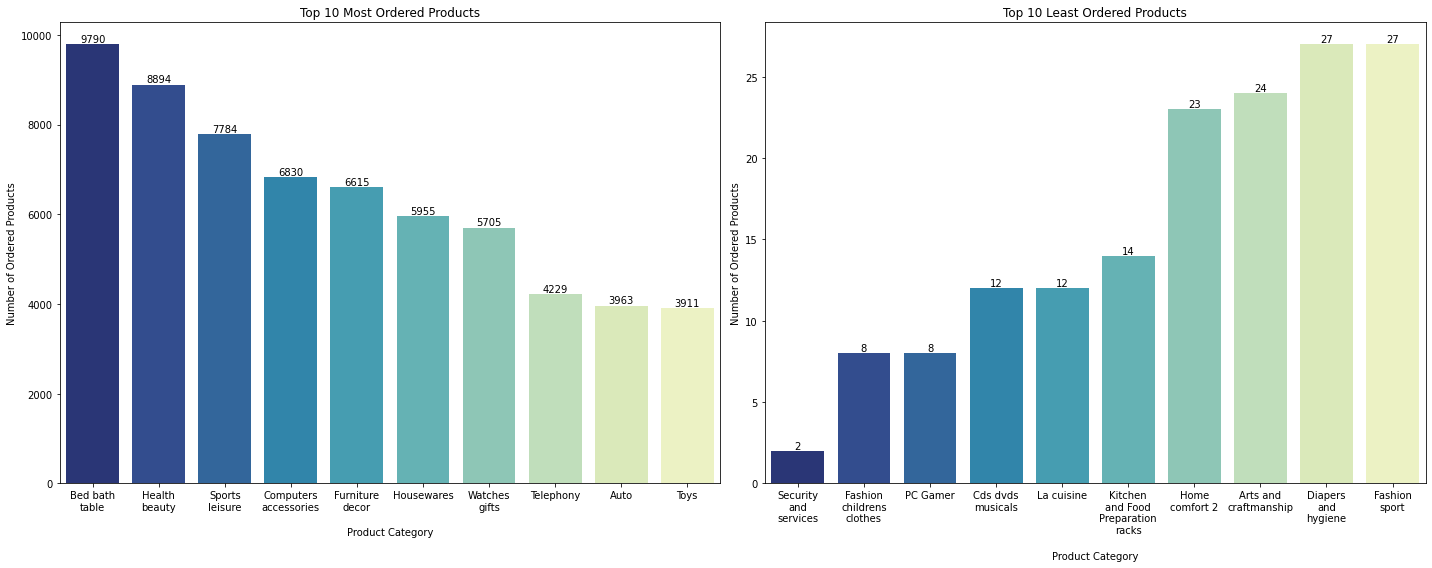

In [ ]:
# Setup the Matplotlib Axes

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

for i, _ in enumerate(axes):
    if (i == 0):
        # set the most ordered products
        data = df_ordered_products.sort_values("order_counts",
                                               ascending=False)
        bar_title = "Top 10 Most Ordered Products"
    elif (i == 1):
        data = df_ordered_products.sort_values("order_counts")
        bar_title = "Top 10 Least Ordered Products"

    sns.barplot(x="product_name", y="order_counts", ax=axes[i],
                palette="YlGnBu_r", data=data[:10])

    wrap_labels(axes[i], 10)
    axes[i].bar_label(axes[i].containers[0])
    axes[i].title.set_text(bar_title)
    axes[i].set_xlabel("\nProduct Category")
    axes[i].set_ylabel("Number of Ordered Products")

plt.tight_layout()
plt.show()



In [ ]:
df_ordered_products.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
order_counts,73.0,1360.945205,2293.162905,2.0,76.0,243.0,1289.0,9790.0


#### **Use Case 2: How Does the Revenue Generated by Each Ordered Products**

In [ ]:
df_pricing = df_main[
        ["product_name", "price"]
    ].groupby("product_name").agg("sum").reset_index()

df_pricing

,product_name,price
0,Agro industry and commerce,14502.33
1,Air conditioning,28867.29
2,Art,17051.27
3,Arts and craftmanship,1603.52
4,Audio,29409.61
...,...,...
68,Stationery,199938.61
69,Tablets printing image,6152.63
70,Telephony,210809.30
71,Toys,342571.45


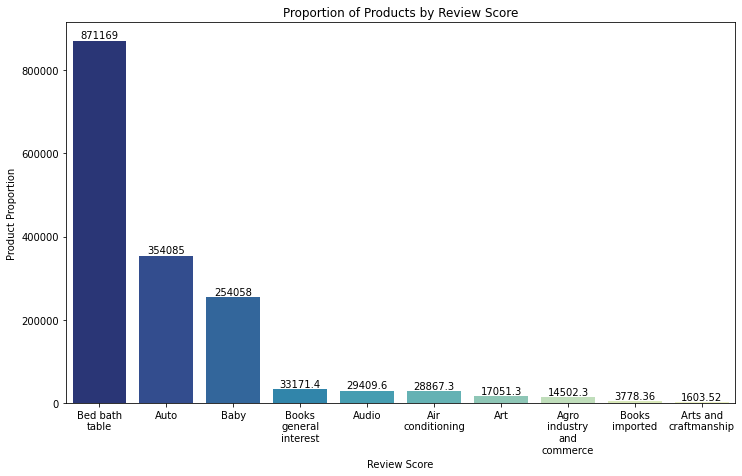

In [ ]:
# Create chart
plt.figure(figsize=(12, 7))

ax = sns.barplot(x="product_name", 
                 y="price",
                 palette="YlGnBu_r", 
                 data=df_pricing[:10],
                 order=df_pricing[:10]
                       .sort_values("price", 
                                     ascending=False).product_name)  
# Adding data label into the graph
wrap_labels(ax, 10)
plt.bar_label(ax.containers[0])

# Adding table name and axes labels
plt.title("Proportion of Products by Review Score")
plt.xlabel("Review Score")
plt.ylabel("Product Proportion")
plt.show()

#### **Use Case 3: How Does the Proportion of Review Score of the Ordered Products?**

In [ ]:
df_review = df_main[["product_name", "review_score"]]
df_review.head()

,product_name,review_score
0,Housewares,4
1,Perfumery,4
2,Auto,5
3,Pet shop,5
4,Stationery,5


In [ ]:
df_review_proportion = df_review.groupby("review_score").agg("count")
df_review_proportion.head()

,product_name
review_score,
1,11395
2,3271
3,8319
4,19123
5,57241


In [ ]:
df_review_proportion.reset_index(inplace=True)
df_review_proportion.head()

,review_score,product_name
0,1,11395
1,2,3271
2,3,8319
3,4,19123
4,5,57241


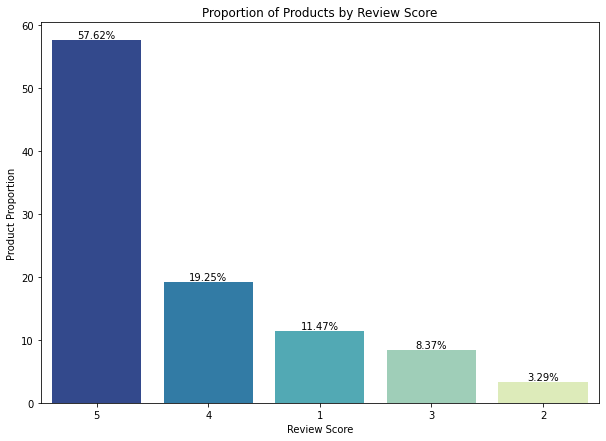

In [ ]:
# Set percentage column on the data frame
percentages = (df_review_proportion["product_name"]\
              / df_review_proportion["product_name"].sum())\
              * 100

df_review_proportion["percentages"] = percentages

# Create chart
plt.figure(figsize=(10, 7))

ax = sns.barplot(x="review_score", 
                 y="percentages",
                 palette="YlGnBu_r", 
                 data=df_review_proportion,
                 order=df_review_proportion
                       .sort_values("percentages", 
                                     ascending=False).review_score)  
# Adding data label into the graph
plt.bar_label(ax.containers[0], fmt="%.2f%%")

# Adding table name and axes labels
plt.title("Proportion of Products by Review Score")
plt.xlabel("Review Score")
plt.ylabel("Product Proportion")
plt.show()

In [ ]:
df_product_review = df_review.groupby(["review_score", "product_name"]).agg("count")
df_product_review

Empty DataFrame
Columns: []
Index: [(1, Agro industry and commerce), (1, Air conditioning), (1, Art), (1, Arts and craftmanship), (1, Audio), (1, Auto), (1, Baby), (1, Bed bath table), (1, Books general interest), (1, Books imported), (1, Books technical), (1, Christmas supplies), (1, Cine photo), (1, Computers), (1, Computers accessories), (1, Consoles games), (1, Construction tools construction), (1, Construction tools lights), (1, Construction tools safety), (1, Cool stuff), (1, Costruction tools garden), (1, Costruction tools tools), (1, Diapers and hygiene), (1, Drinks), (1, Dvds blu ray), (1, Electronics), (1, Fashio female clothing), (1, Fashion bags accessories), (1, Fashion childrens clothes), (1, Fashion male clothing), (1, Fashion shoes), (1, Fashion sport), (1, Fashion underwear beach), (1, Fixed telephony), (1, Flowers), (1, Food), (1, Food drink), (1, Furniture bedroom), (1, Furniture decor), (1, Furniture living room), (1, Furniture mattress and upholstery), (1, Garden tools), (1, Health beauty), (1, Home appliances), (1, Home appliances 2), (1, Home comfort 2), (1, Home confort), (1, Home construction), (1, Housewares), (1, Industry commerce and business), (1, Kitchen and Food Preparation racks), (1, Kitchen dining laundry garden furniture), (1, La cuisine), (1, Luggage accessories), (1, Market place), (1, Music), (1, Musical instruments), (1, Office furniture), (1, PC Gamer), (1, Party supplies), (1, Perfumery), (1, Pet shop), (1, Security and services), (1, Signaling and security), (1, Small appliances), (1, Small appliances home oven and coffee), (1, Sports leisure), (1, Stationery), (1, Tablets printing image), (1, Telephony), (1, Toys), (1, Watches gifts), (2, Agro industry and commerce), (2, Air conditioning), (2, Art), (2, Audio), (2, Auto), (2, Baby), (2, Bed bath table), (2, Books general interest), (2, Books imported), (2, Books technical), (2, Christmas supplies), (2, Cine photo), (2, Computers), (2, Computers accessories), (2, Consoles games), (2, Construction tools construction), (2, Construction tools lights), (2, Construction tools safety), (2, Cool stuff), (2, Costruction tools garden), (2, Drinks), (2, Dvds blu ray), (2, Electronics), (2, Fashio female clothing), (2, Fashion bags accessories), (2, Fashion male clothing), (2, Fashion shoes), (2, Fashion sport), ...]

[348 rows x 0 columns]

In [ ]:
df_product_review.reset_index(inplace=True)
df_product_review.rename(columns={"order_id": "product_counts"})

df_product_review.head()

,review_score,product_name
0,1,Agro industry and commerce
1,1,Air conditioning
2,1,Art
3,1,Arts and craftmanship
4,1,Audio


KeyError: 'order_id'

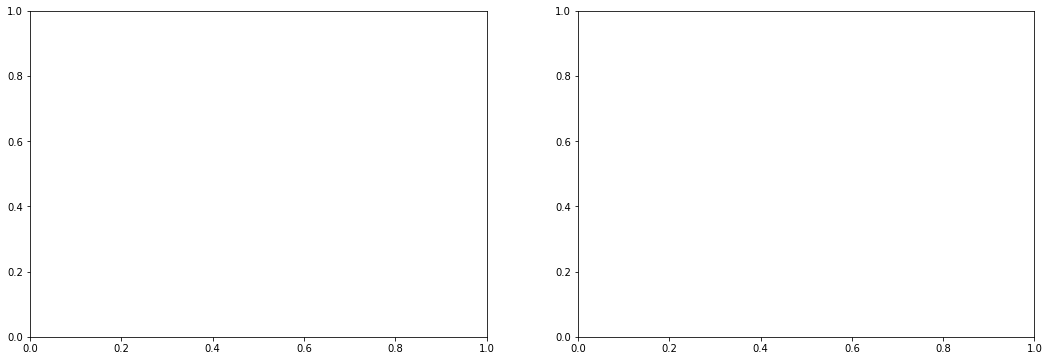

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

for i, _ in enumerate(axes):
      if i == 0:
            data = df_product_review[df_product_review["review_score"] == 5][:10]
            bar_title = "Top 10 Products with the Highest Review Score"
      elif i == 1:
            data = df_product_review[df_product_review["review_score"] == 1][:10]
            bar_title = "Top 10 Products with the Lowest Review Score"
      
      bar_plot = sns.barplot(x="product_name",
                             y="order_id",
                             ax=axes[i],
                             palette="YlGnBu_r",
                             data=data,
                             order=data.sort_values("order_id", 
                                                    ascending=False).product_name)

      wrap_labels(axes[i], 10)
      axes[i].bar_label(axes[i].containers[0])
      axes[i].title.set_text(bar_title)
      axes[i].set_xlabel("\nProdut Category Name")
      axes[i].set_ylabel("Number of Product Categories")

plt.tight_layout()